This file contains python code to check the hypothesis testing

In [1]:
import sys
sys.path.append("../mypkg")

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
#import xarray as xr
from scipy.stats import pearsonr
from numbers import Number
import multiprocessing as mp

from easydict import EasyDict as edict
from tqdm import trange,tqdm
from scipy.io import loadmat
from pprint import pprint


In [4]:
import importlib
import constants
importlib.reload(constants)

<module 'constants' from '/data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/constants.py'>

In [5]:
from constants import DATA_ROOT, RES_ROOT, FIG_ROOT, MIDRES_ROOT
from default_paras import def_paras

from hdf_utils.data_gen import gen_covs, gen_simu_psd, gen_simu_ts
from hdf_utils.fns import fn1, fn2, fn3, fn4, fn5, zero_fn
from hdf_utils.fns_sinica import coef_fn, fourier_basis_fn
from hdf_utils.likelihood import obt_lin_tm
from hdf_utils.SIS import SIS_linear
from utils.matrix import col_vec_fn, col_vec2mat_fn, conju_grad, svd_inverse
from utils.functions import logit_fn
from utils.misc import save_pkl, load_pkl
from splines import obt_bsp_basis_Rfn, obt_bsp_basis_Rfn_wrapper
from projection import euclidean_proj_l1ball
from optimization.one_step_opt import OneStepOpt
from optimization.cross_validation import CV_err_linear_fn
from optimization.opt import optimization

from penalties.scad_pen import SCAD
from models.logistic_model import LogisticModel
from models.linear_model import LinearModel


Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/AD88_all.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../data/AD_vs_Ctrl_ts/Ctrl92_all.pkl
Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../data/ctrl_vs_AD_nooutlier.pkl


In [6]:
plt.style.use(FIG_ROOT/"base.mplstyle")

In [7]:
torch.set_default_tensor_type(torch.DoubleTensor)

## Param and fns

### Params

In [142]:
np.random.seed(0)
paras = edict(def_paras.copy())

# Others
paras.num_rep = 20
paras.ns = [100, 300, 900, 2700, 8100, 24300]
paras.can_lams = [1e-1, 3e-1, 1e0, 3e0, 9e0, 3e1]
paras.can_Ns = [5, 10, 15, 20]
paras.ind_freq = np.linspace(1, 40, 40) # freqs
paras.init_noise_sd = 0 # the sd of the noise added to the true value for initial values
#paras.SIS_ratio = 1 # the ratio to keep with SIS procedure
paras.SIS_ratio = 0.02 # the ratio to keep with SIS procedure
paras.svdinv_eps = 0.999

# generating dataset
paras.n = 1000 # num of data obs to be genareted
paras.npts = 100 # num of pts to evaluate X(s)
paras.d = 200 # num of ROIs
paras.q = 5 # num of other covariates
paras.sigma2 = 1 # variance of the error
paras.types_ = ["int", 2, 2, "c", "c"]

# b-spline
paras.N = 6 # int(3*paras.n**(1/paras.ord/2)) # num of basis for bsp
paras.x = np.linspace(0, 1, paras.npts)
paras.basis_mat = torch.DoubleTensor(obt_bsp_basis_Rfn_wrapper(paras.x, paras.N, paras.ord))
assert paras.N == paras.basis_mat.shape[1]
print(f"The number of B-spline basis is {paras.N:.0f}.")

# True parameters
paras.alp_GT = np.array([5, 1, -2, 3, -4])

# first way
#beta_type_GT = [fn1, fn2, fn2] + [zero_fn]*(paras.d-3-2) + [fn1, fn2]
#paras.beta_GT = np.array([_fn(paras.x) for _fn in beta_type_GT]).T
# second way, fourier basis
paras.fourier_basis = fourier_basis_fn(paras.x)
#paras.fourier_basis_coefs = ([coef_fn(0.1), coef_fn(0.3), coef_fn(0.5)] + 
#                             [np.zeros(50)] * (paras.d-3-2) +
#                             [coef_fn(0.7), coef_fn(0.9)]
#                             )
paras.fourier_basis_coefs = ([np.zeros(50)] * (paras.d-2) +
                             [coef_fn(0.7), coef_fn(0.9)]
                             )
paras.fourier_basis_coefs = np.array(paras.fourier_basis_coefs).T * 5
paras.beta_GT = paras.fourier_basis @ paras.fourier_basis_coefs #* 10
#
paras.Gam_GT_est = (np.linalg.inv(paras.basis_mat.numpy().T 
                               @ paras.basis_mat.numpy()) 
                               @ paras.basis_mat.numpy().T 
                               @ paras.beta_GT)

# optimization
paras.Rmin = 2*(np.linalg.norm(paras.Gam_GT_est/np.sqrt(paras.N), axis=0).sum() + np.abs(paras.alp_GT).sum())
paras.sel_idx = np.arange(2, paras.d) # M^c set, 
#without loss of generality, we assume the idxs in M is the first m betas
paras.num_cv_fold = 5
paras.Rfct = 2
paras.stop_cv = 5e-5
#paras.stop_cv = 5e-4
#paras.max_iter = 10000
paras.max_iter = 2000

# hypothesis test
paras.M_idxs = np.delete(np.arange(paras.d), paras.sel_idx) # the M set
paras.Cmat = np.eye(len(paras.M_idxs)) # Cmat \times beta_M(s), r x m
paras.r, paras.m = paras.Cmat.shape
paras.t_vec = np.zeros(paras.Cmat.shape[0]) # t vec, typically it is zero vector


The number of B-spline basis is 6.


In [143]:
paras.save_dir = RES_ROOT/"linear_test"
if not paras.save_dir.exists():
    paras.save_dir.mkdir()

### Fns

In [144]:

def MS2idxs(q, N, MS_unions):
    """This fn is to return the idxs to keep in mat Q, Sigma and vec Theta
    """
    idxs_all = [np.arange(0, q)]
    for cur_idx in MS_unions:
        idxs_all.append(np.arange(q+cur_idx*N, q+(cur_idx+1)*N))
    idxs_all = np.concatenate(idxs_all)
    return idxs_all

In [145]:
def get_Amat(k, paras):
    """Get A matrix for hypothesis test
        k: Num of elements in S
        paras: parameters
                required: N, Cmat, m, q
    """
    _paras = edict(paras.copy())
    
    part1 = np.kron(_paras.Cmat, np.eye(_paras.N))
    part2 = np.zeros((_paras.m*_paras.N, _paras.q+(_paras.m+k)*_paras.N))
    part2[:, _paras.q:(_paras.q+_paras.m*_paras.N)] = np.eye(_paras.m*_paras.N)
    A = part1 @ part2
    return A

In [146]:
def get_filename(params):
    keys = ["seed", "n", "d", "decimate_rate"]
    return '_'.join(f"{k}-{params[k]}" for k in keys) + '.pkl'
def _gen_simu_data_all(seed, paras):
    np.random.seed(seed)
    _paras = edict(paras.copy())
    # simulated PSD
    assert len(_paras.types_) == _paras.q
    assert len(_paras.alp_GT) == _paras.q
    tmp_paras = edict()
    tmp_paras.seed = seed 
    tmp_paras.n = _paras.n
    tmp_paras.d = _paras.d
    tmp_paras.decimate_rate = 30
    
    file_path = MIDRES_ROOT/get_filename(tmp_paras)
    if file_path.exists():
        #simu_curvs = np.random.randn(_paras.n, _paras.d, _paras.npts) /10
        simu_curvs = load_pkl(file_path, verbose=False)
    else:
        simu_curvs = gen_simu_ts(_paras.n, _paras.d, 5, decimate_rate=tmp_paras.decimate_rate, verbose=False)
        save_pkl(file_path, simu_curvs)
    #simu_curvs = gen_simu_psd(_paras.n, _paras.d, 10)
    #simu_curvs = 1*(simu_curvs- simu_curvs.mean(axis=2, keepdims=True))/simu_curvs.std(axis=2, keepdims=True)
    #simu_curvs = np.random.randn(_paras.n, _paras.d, _paras.npts) * 20
    #simu_curvs = (simu_curvs)/simu_curvs.std(axis=2)[:, :, np.newaxis]
    #simu_curvs = simu_curvs + np.random.randn(_paras.n, _paras.d, 1)*0.5
    simu_curvs = simu_curvs[:, :, :_paras.npts]
    simu_covs = gen_covs(_paras.n, _paras.types_)
    
    # linear term and Y
    int_part = np.sum(_paras.beta_GT.T* simu_curvs[:, :, :], axis=1).mean(axis=1)
    cov_part = simu_covs @ _paras.alp_GT 
    
    # linear term
    lin_term = cov_part + int_part
    
    
    
    # Y 
    rvs = np.random.rand(_paras.n)
    Y = lin_term + np.random.randn(_paras.n)*np.sqrt(_paras.sigma2)
    
    # To torch
    X = torch.Tensor(simu_curvs) # n x d x npts
    Z = torch.Tensor(simu_covs) # n x q
    Y = torch.Tensor(Y)
    
    all_data = edict()
    all_data.X = X
    all_data.Y = Y
    all_data.Z = Z
    return all_data

In [147]:
def obt_test_stat(model, est_alp, est_Gam, paras):
    """Obtiaining the test statistics via the estimator
        args:
            model: The model you used, LinearModel or LogisticModel
            est_alp: Estimated alp parameters
            est_Gam: Estimated Gam parameters
    """
    _paras = edict(paras.copy())
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    Q_mat = -model.log_lik_der2(est_alp, est_Gam)
    model.log_lik_der1(est_alp, est_Gam);
    Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
    # minus sign canceled
    
    
    # obtain the idxs to keep for test
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
    keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
    
    # A mat
    k = len(np.setdiff1d(nonzero_idxs, _paras.M_idxs))
    Amat = torch.Tensor(get_Amat(k, _paras))
    
    # calcuate Test stats
    Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
    Q_mat_part_inv = svd_inverse(Q_mat_part, _paras.svdinv_eps)
    
    Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
    Psi = Amat @ Q_mat_part_inv @ Sig_mat_part @ Q_mat_part_inv @ Amat.T
    
    T_p1 = Amat @ est_theta[keep_idxs_test]
    Psi_inv = svd_inverse(Psi, _paras.svdinv_eps)
    T_v = T_p1 @ Psi_inv @ T_p1 * _paras.n 
    return T_v

## Check

In [148]:
seed = 1
lam = 1.0
#cur_data = _gen_simu_data_all(_paras.seed, paras)
    
def run(seed, paras):
    np.random.seed(seed)
    torch.manual_seed(seed)
    est_Gam_full = torch.zeros_like(torch.tensor(paras.Gam_GT_est));
        
    _paras = edict(paras.copy())
    #_paras.lam = lam
    _paras.seed = seed
    _paras.Rv = _paras.Rfct * _paras.Rmin
    cur_data = _gen_simu_data_all(seed, _paras)
    
    
    # do sure independent screening for dim reduction
    if _paras.SIS_ratio < 1:
        keep_idxs, _  = SIS_linear(cur_data.Y, cur_data.X, cur_data.Z, _paras.SIS_ratio, _paras, ridge_pen=1)
    else:
        keep_idxs = _paras.sel_idx
    M_idxs = np.delete(np.arange(_paras.d), _paras.sel_idx)
    _paras.keep_idxs = np.sort(np.concatenate([M_idxs, keep_idxs]))
        
    _paras.sel_idx_SIS = np.where(np.array([keep_idx in _paras.sel_idx for keep_idx in _paras.keep_idxs]))[0]
    _paras.d_SIS = len(_paras.keep_idxs)
    
    cur_data_SIS = edict(cur_data.copy())
    cur_data_SIS.X = cur_data.X[:, _paras.keep_idxs, :]
    
    
    alp_init = torch.Tensor(_paras.alp_GT) + torch.randn(_paras.q)*_paras.init_noise_sd
    Gam_init = (torch.Tensor(_paras.Gam_GT_est[:, _paras.keep_idxs]) 
                + torch.randn(_paras.N, _paras.d_SIS)*_paras.init_noise_sd)
    theta_init = torch.cat([alp_init, col_vec_fn(Gam_init)/np.sqrt(_paras.N)])
    rhok_init = torch.randn(_paras.d_SIS*_paras.N)
        
    model = LinearModel(Y=cur_data_SIS.Y, 
                        X=cur_data_SIS.X, 
                        Z=cur_data_SIS.Z, 
                        basis_mat=_paras.basis_mat, 
                        sigma2=_paras.sigma2)
    # 3e0
    pen = SCAD(lams=_paras.lam, a=_paras.a,  sel_idx=_paras.sel_idx_SIS)
        
    
    main_res = optimization(model=model, 
                            penalty=pen, 
                            inits=[alp_init, Gam_init, theta_init, rhok_init],
                            is_prg=False,
                            save_paras=False,    
                            input_paras=_paras)
    
    opt = main_res[0]
    est_Gam = opt.Gamk
    est_alp = opt.alpk
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    est_Gam_full[:, _paras.keep_idxs] = est_Gam.clone()
    
    Q_mat = -model.log_lik_der2(est_alp, est_Gam)
    model.log_lik_der1(est_alp, est_Gam);
    Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
    # minus sign canceled
    
    
    # obtain the idxs to keep for test
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
    keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
    
    # A mat
    k = len(np.setdiff1d(nonzero_idxs, _paras.M_idxs))
    Amat = torch.Tensor(get_Amat(k, _paras))
    
    # calcuate Test stats
    Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
    Q_mat_part_inv = svd_inverse(Q_mat_part, _paras.svdinv_eps)
    
    Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
    Psi = Amat @ Q_mat_part_inv @ Sig_mat_part @ Q_mat_part_inv @ Amat.T
    
    T_p1 = Amat @ est_theta[keep_idxs_test]
    Psi_inv = svd_inverse(Psi, _paras.svdinv_eps)
    T_v = T_p1 @ Psi_inv @ T_p1 * _paras.n 
    
    res = edict()
    res.Psi = Psi
    res.T_v = T_v
    res.Sig_mat = Sig_mat_part
    res.Q_mat_part = Q_mat_part
    res.nonzero_idxs = nonzero_idxs
    res.keep_idxs_test = keep_idxs_test
    res.keep_idxs = keep_idxs
    res.model = model
    res.est_Gam = est_Gam
    res.est_alp = est_alp
    return res

In [149]:
T_vs, tparas = load_pkl(MIDRES_ROOT/f"T_vs_res452.pkl");
T_vs = np.array(T_vs);
print(f"The df of chisq is {tparas.r * tparas.N}.")

Load file /data/rajlab1/user_data/jin/MyResearch/HDF_infer/notebooks/../mypkg/../mid_results/T_vs_res452.pkl
The df of chisq is 12.


In [310]:
large_seeds = np.where(T_vs>100)[0];
good_seeds = np.where(np.bitwise_and(T_vs>0, T_vs<30))[0];

cur_paras = edict(tparas.copy())
cur_paras.svdinv_eps = 0.99
cur_paras.sigma2 = 1
cur_paras.npts = 100

In [311]:
large_ress = []
for lseed in tqdm(large_seeds[:10]):
    #cur_data = _gen_simu_data_all(lseed, cur_paras)
    large_ress.append(run(lseed,  cur_paras))

 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 9/10 [02:53<00:18, 18.01s/it]

The optimization may not converge with stop value 5.009E-05


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [03:11<00:00, 19.13s/it]


In [294]:
if True:
    good_ress = []
    for gseed in tqdm(good_seeds[:10]):
        #cur_data = _gen_simu_data_all(gseed, cur_paras)
        good_ress.append(run(gseed,  cur_paras))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:17<00:00,  7.77s/it]


## Analysis

In [312]:
for cur_seed, res in zip(large_seeds, large_ress):
    print(res.keep_idxs, res.nonzero_idxs, res.T_v, T_vs[cur_seed])

[ 77 146 198 199] [0 1 4 5] tensor(179.8866) 179.88655217429906
[122 148 198 199] [0 1 4 5] tensor(251.6365) 251.63647976894364
[ 61 180 198 199] [0 1 4 5] tensor(283.6828) 283.6828043413423
[  8 140 198 199] [0 1 4 5] tensor(272.3910) 272.39100461333356
[110 133 198 199] [0 1 4 5] tensor(406.4239) 406.4239070966155
[ 20 145 198 199] [0 1 4 5] tensor(283.6654) 283.6654330206331
[169 189 198 199] [0 1 4 5] tensor(108.2869) 108.28689040381117
[ 74 174 198 199] [0 1 4 5] tensor(331.8448) 331.84476672543815
[ 49  98 198 199] [0 1 4 5] tensor(117.5644) 117.56443682898995
[ 75 101 198 199] [0 1 4 5] tensor(130.0853) 130.08526659976283


In [313]:
for cur_seed, res in zip(good_seeds, good_ress):
    print(res.keep_idxs, res.nonzero_idxs, res.T_v, T_vs[cur_seed])

[  7  50 198 199] [0 1 4 5] tensor(6.0949) 6.094867254646679
[ 25  77 198 199] [0 1 4 5] tensor(10.5515) 10.551492795876067
[ 60 145 198 199] [0 1 4 5] tensor(4.0259) 4.025918125050123
[115 165 198 199] [0 1 4 5] tensor(5.9923) 5.992253196832215
[ 97 133 198 199] [0 1 4 5] tensor(11.0164) 11.016401582316634
[ 81 173 198 199] [0 1 4 5] tensor(20.7508) 20.750802512435342
[ 14  33 198 199] [0 1 4 5] tensor(9.5770) 9.577017291993666
[ 58 157 198 199] [0 1 4 5] tensor(11.3236) 11.323624112811
[ 17 162 198 199] [0 1 4 5] tensor(2.5931) 2.5931060885799075
[158 167 198 199] [0 1 4 5] tensor(10.4540) 10.453974537130762


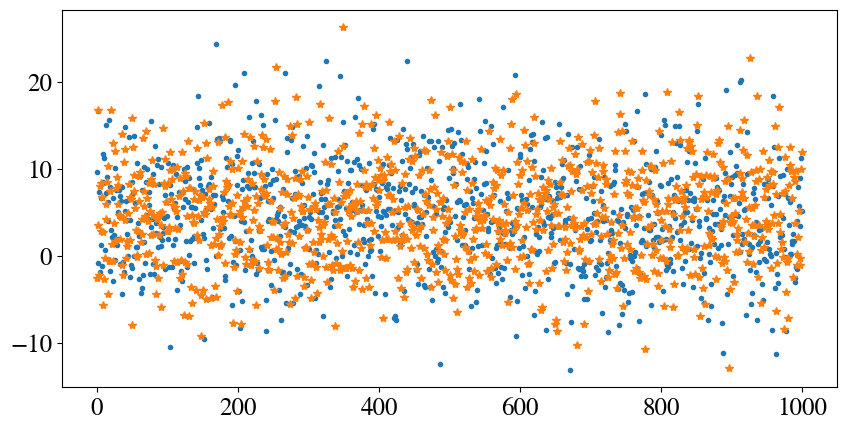

In [314]:
lres = large_ress[0]
gres = good_ress[0]
plt.plot(lres.model.Y, ".")
plt.plot(gres.model.Y, "*")

In [428]:
def obt_test_stat1(model, est_alp, est_Gam, paras):
    """Obtiaining the test statistics via the estimator
        args:
            model: The model you used, LinearModel or LogisticModel
            est_alp: Estimated alp parameters
            est_Gam: Estimated Gam parameters
    """
    _paras = edict(paras.copy())
    est_theta = torch.cat([est_alp, col_vec_fn(est_Gam)/np.sqrt(_paras.N)])
    Q_mat = -model.log_lik_der2(est_alp, est_Gam)
    model.log_lik_der1(est_alp, est_Gam);
    Sig_mat = (model.log_lik_der1_vs.unsqueeze(-1) * model.log_lik_der1_vs.unsqueeze(1)).mean(axis=0) 
    # minus sign canceled
    
    
    # obtain the idxs to keep for test
    nonzero_idxs = torch.nonzero(torch.norm(est_Gam, dim=0)).reshape(-1).numpy()
    MS_unions = np.sort(np.union1d(_paras.M_idxs, nonzero_idxs))
    keep_idxs_test = MS2idxs(_paras.q, _paras.N, MS_unions)
    
    # A mat
    k = len(np.setdiff1d(nonzero_idxs, _paras.M_idxs))
    Amat = torch.Tensor(get_Amat(k, _paras))
    
    # calcuate Test stats
    Q_mat_part = Q_mat[keep_idxs_test][:, keep_idxs_test]
    #Q_mat_part_inv = torch.pinverse(Q_mat_part)
    Q_mat_part_inv = svd_inverse(Q_mat_part, 0.999)
    
    Sig_mat_part = Sig_mat[keep_idxs_test][:, keep_idxs_test]
    Psi = Amat @ Q_mat_part_inv @ Sig_mat_part @ Q_mat_part_inv @ Amat.T
    
    T_p1 = Amat @ est_theta[keep_idxs_test]
    #Psi_inv = torch.pinverse(Psi)
    Psi_inv = svd_inverse(Psi, _paras.svdinv_eps)
    #print(Psi_inv)
    T_v = T_p1 @ Psi_inv @ T_p1 * _paras.n 
    return T_v



In [430]:
ix = 1
cur_paras.svdinv_eps = 0.999
for ix in range(10):
    print(obt_test_stat1(
                  good_ress[ix].model, 
                  good_ress[ix].est_alp,
                  good_ress[ix].est_Gam,
                  cur_paras).item())

370.6154079523257
7.6555661173036835
4.997027387394482
14.144125855101281
15.404911373027206
15.851100580130186
15.863699107907362
12.796658566648917
9.678703258707912
5.250914968085727


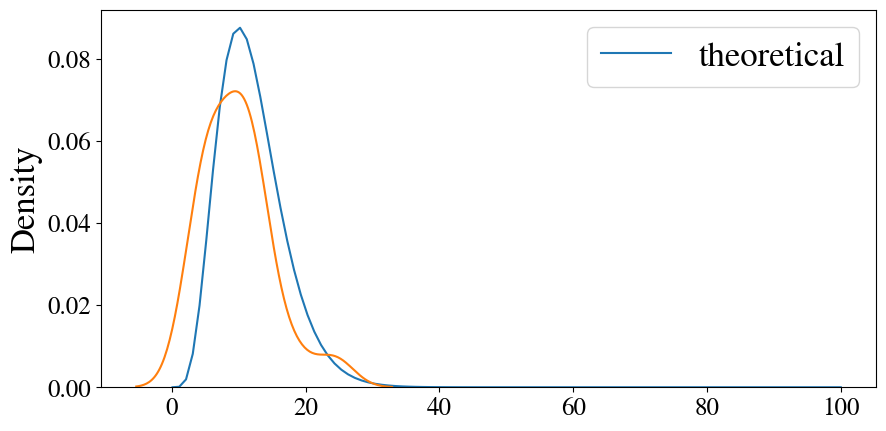

In [384]:

cur_paras.svdinv_eps = 0.999
vs = []
for ix in range(10):
    vs.append(obt_test_stat1(
                  large_ress[ix].model, 
                  large_ress[ix].est_alp,
                  large_ress[ix].est_Gam,
                  cur_paras).item())
for ix in range(10):
    vs.append(obt_test_stat1(
                  good_ress[ix].model, 
                  good_ress[ix].est_alp,
                  good_ress[ix].est_Gam,
                  cur_paras).item())
    
from scipy.stats import chi2
chi_df = cur_paras.r*cur_paras.N
xs = np.linspace(0.1, 100, 100)
theo_curvs_log = chi2.logpdf(xs, chi_df);
plt.plot(xs, np.exp(theo_curvs_log) , label="theoretical")
sns.kdeplot(vs)
plt.legend()

In [350]:
def svd_inverse1(mat, eps=0.999):
    """This fn is to caculate inverse for mat with SVD decom
    """
    res = torch.svd(mat)
    
    # to avoid non-inveritble matrix
    sing_v_ratios = torch.cumsum(res.S, dim=0)/torch.sum(res.S)
    idx = torch.where(sing_v_ratios >= eps)[0][0] + 1
    #print(res.S[:idx], res.S)
    
    inv_mat = res.V[:, :idx] @ torch.diag(1/res.S[:idx]) @ res.U.T[:idx, :]
    return inv_mat, idx.item(), res.S

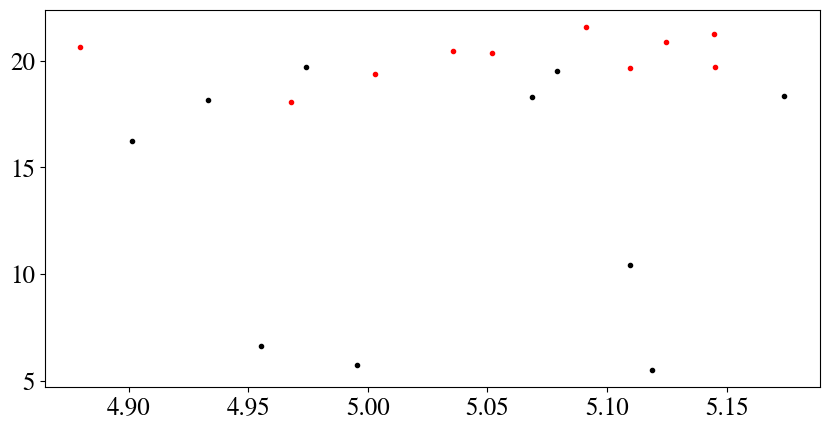

In [279]:
for res in good_ress:
    eps = np.random.randn(1) * 0.1
    #eps = 0
    _, idx, cur_S = svd_inverse1(res.Psi, 0.99)
    #plt.plot(cur_S, ".", color="blue")
    plt.plot(idx-1+eps, cur_S[idx-1], ".r", label="good")
for res in large_ress:
    eps = np.random.randn(1) * 0.1
    #eps = 0
    _, idx, cur_S = svd_inverse1(res.Psi, 0.99)
    #plt.plot(cur_S, ".", color="green")
    plt.plot(idx-1+eps, cur_S[idx-1], ".k", label="large")
#plt.yscale("log")

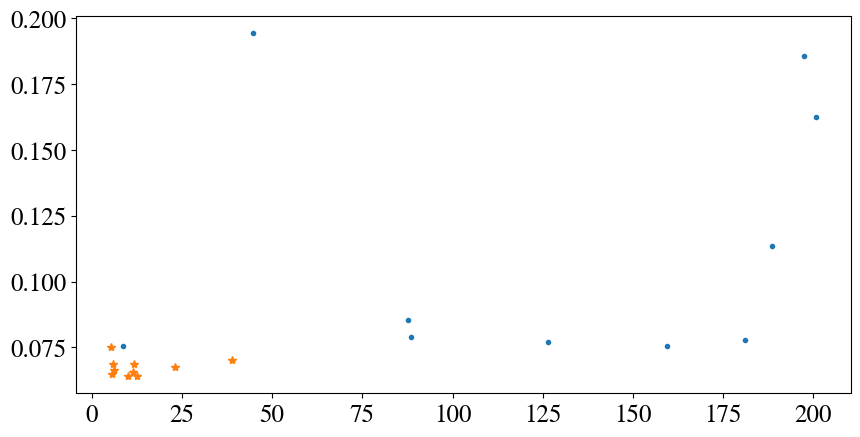

In [280]:
v1 = [torch.norm(svd_inverse(res.Psi, 0.99)).item() for res in large_ress]
v11 = [res.T_v for res in large_ress]
v2 = [torch.norm(svd_inverse(res.Psi, 0.99)).item() for res in good_ress]
v21 = [res.T_v for res in good_ress]
plt.plot(v11, v1, ".")
plt.plot(v21, v2, "*")